In [8]:
%load_ext autoreload
%autoreload 2
%run nnn/ipynb_init.py
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import nupack

In [10]:
agg_result_file='./data/uv_melt/uvmelt_agg_230502.csv'
uv_df = pd.read_csv(agg_result_file, index_col=1)
arr = pd.read_csv('./data/models/raw/arr_v0.csv', index_col=0)
data_split_dict = fileio.read_json('./data/models/raw/data_split.json')

FileNotFoundError: [Errno 2] No such file or directory: './data/models/raw/arr_v0.csv'

# Update data split

Remove the variants measured by UV melting from the training set.

In [12]:
# arr = pd.read_csv('./data/models/raw/arr_v0.csv', index_col=0)
# arr.dropna(subset=['Series'], inplace=True)
arr_1M = pd.read_csv('./data/models/raw/arr_1M.csv', index_col=0)

FileNotFoundError: [Errno 2] No such file or directory: './data/models/raw/arr_1M.csv'

In [339]:
from sklearn.model_selection import train_test_split

ind2split = list(set(arr_1M.index) - set(uv_df.index))
series2split = arr_1M.loc[ind2split, 'Series']

train_val_ind, test_ind = train_test_split(ind2split, test_size=.05,
                                       random_state=42, stratify=series2split)
train_ind, val_ind = train_test_split(arr_1M.loc[train_val_ind,:].index, test_size=.05,
                                      random_state=43, stratify=arr_1M.loc[train_val_ind,:].Series)
test_ind += list(set(uv_df.index) & set(arr.index))
n_train, n_val, n_test = len(train_ind), len(val_ind), len(test_ind)
print(n_train, n_val, n_test)

split_dict = dict(train_ind=train_ind.tolist(),
                  val_ind=val_ind.tolist(),
                  test_ind=test_ind)
with open('./data/models/raw/data_split.json', 'w') as fh:
    json.dump(split_dict, fh, indent=4)

27783 1463 1607


In [248]:
len(set(uv_df.index) & set(arr.index))

67

# First attempt

I overwrote the triloop parameters in the parameter set file and saw a change in the prediction results. More salt and offset correction needs to be applied before it is usable.

In [8]:
[x for x in uv_df.index if x.startswith('TRI')]

['TRINNN162',
 'TRINNN162',
 'TRINNN445',
 'TRINNN452',
 'TRINNN470',
 'TRINNN512',
 'TRINNN520',
 'TRINNN544']

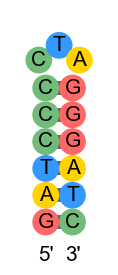

-1.9906842590104945

In [96]:
seqid = 'TRINNN996'
seq = arr.loc[seqid, 'RefSeq']
struct = arr.loc[seqid, 'TargetStruct']
draw_struct(seq, struct)

arr.loc[seqid, 'dG_37']#, uv_df.loc[seqid, 'dG_37_uv'], arr.loc[seqid, 'dH'], uv_df.loc[seqid, 'dH_uv']

In [87]:
util.get_seq_ensemble_dG(seq, celsius=37, sodium=0.088)

-3.0344754698584784

In [88]:
util.get_seq_ensemble_dG(seq, celsius=37, sodium=1)

-4.353346051253523

In [97]:
util.get_nupack_dH_dS_Tm_dG_37(seq, struct, sodium=0.088, return_dict=True, param_set='dna04')

{'dH': -39.59999999999999,
 'dS': -0.11940253556642866,
 'Tm': 58.501248544624445,
 'dG_37': -2.567303594072143}

In [98]:
util.get_nupack_dH_dS_Tm_dG_37(seq, struct, sodium=0.088, return_dict=True, param_set='./models/dna-nnn.json')

{'dH': -34.73214998436219,
 'dS': -0.10932023314550882,
 'Tm': 44.56017116412988,
 'dG_37': -0.8264796742826314}

In [100]:
util.get_nupack_dH_dS_Tm_dG_37(seq, struct, sodium=0.088, return_dict=True, param_set='./models/dna-nnn.json')

{'dH': -34.73214998436219,
 'dS': -0.10932023314550882,
 'Tm': 44.56017116412988,
 'dG_37': -0.8264796742826314}

In [30]:
lr = fileio.read_pickle('./data/models/saved/ols_dG_37_model.pkl')

In [41]:
triloop_param = lr.coef_df.loc[[x for x in lr.coef_df.index if x.endswith('_...')]]
closing_param = lr.coef_df.loc[[x for x in lr.coef_df.index if x.endswith('_(+)')]]

triloop_list = []
param_list = []
for triloop in triloop_param.index:
    for closing in closing_param.index:
        closing_pair = closing.split('_')[0]
        full_triloop = closing_pair[0] + triloop.split('_')[0] + closing_pair[2]
        triloop_list.append(full_triloop)
        param_list.append(triloop_param.loc[triloop][0] + closing_param.loc[closing][0])
        
triloop_df = pd.DataFrame(index = triloop_list, data=param_list, columns=['dG_37'])

In [43]:
param_set_file = './models/dna-nnn.json'
param_set_dict = fileio.read_json(param_set_file)

triloop_dict = triloop_df.to_dict()
param_set_dict['dG']['hairpin_triloop'] = triloop_dict['dG_37']

In [58]:
param_set_dict['dG']['hairpin_triloop']

{'AAAAT': 0.7028274277094955,
 'CAAAG': -0.2779713094583732,
 'GAAAC': 0.40048998584186846,
 'TAAAA': 0.37452855603513335,
 'AAACT': 0.5710587369609939,
 'CAACG': -0.40974000020687484,
 'GAACC': 0.2687212950933668,
 'TAACA': 0.24275986528663168,
 'AAAGT': 0.6412419827926623,
 'CAAGG': -0.3395567543752063,
 'GAAGC': 0.3389045409250353,
 'TAAGA': 0.3129431111183002,
 'AAATT': 0.8472064135173741,
 'CAATG': -0.13359232365049456,
 'GAATC': 0.544868971649747,
 'TAATA': 0.518907541843012,
 'AACAT': 0.3581004563534656,
 'CACAG': -0.622698280814403,
 'GACAC': 0.05576301448583852,
 'TACAA': 0.029801584679103446,
 'AACCT': 0.50036910873936,
 'CACCG': -0.48042962842850867,
 'GACCC': 0.19803166687173296,
 'TACCA': 0.1720702370649979,
 'AACGT': 0.6233372274434811,
 'CACGG': -0.3574615097243876,
 'GACGC': 0.320999785575854,
 'TACGA': 0.2950383557691189,
 'AACTT': 0.5343097131946686,
 'CACTG': -0.44648902397320017,
 'GACTC': 0.23197227132704146,
 'TACTA': 0.20601084152030635,
 'AAGAT': 0.7012536296016

In [60]:
fileio.write_json(param_set_dict, param_set_file)

# Applying adjustments to triloops

Here I correct array data with systematic offset in Tm, salt correct to 1M Na, fit triloop parameters , and adjust the offset based on the way NUPACK parameterizes things.

## Adjust offset

Simply add an offset to Tm and adjust dG_37 and dS.

(-4.0, 0.0)

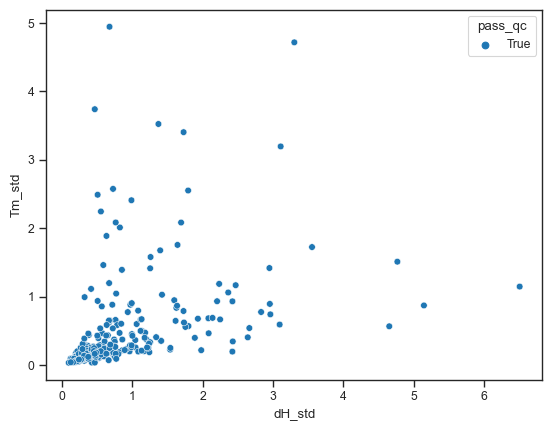

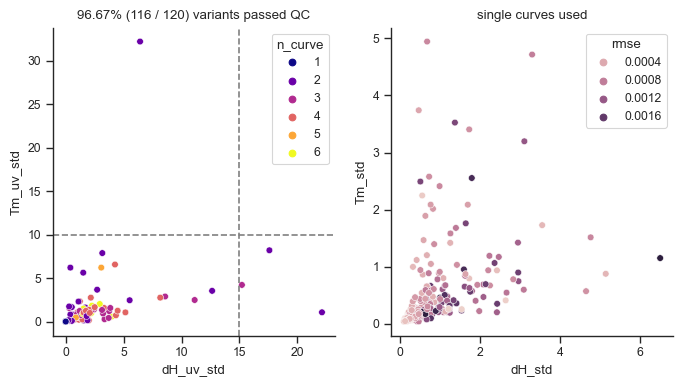

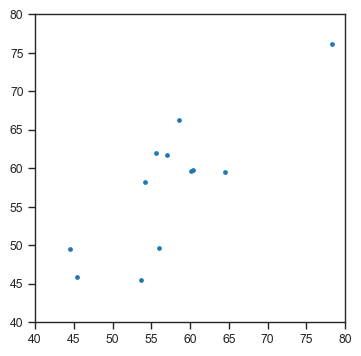

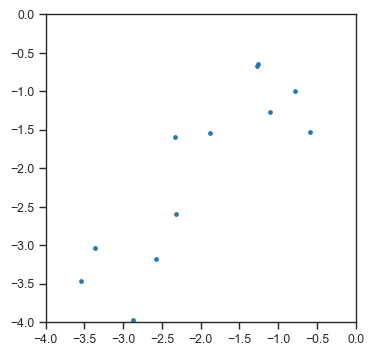

In [159]:
"""
Get the offset the violent way
"""
# copy pasted from command center for convenience
# only one peak found by AnalyzePeaks
hplc_clean_seqid = ["WC68_stem_3p", "WC68_stem_5p", "WC1025_split_5p", \
"WC1025_split_3p", "WC1375_stem_5p", "WC1375_stem_3p", "DMM004_5p", \
"DMM004_3p", "DMM005_5p", "DMM005_3p", "DMM006_5p", "DMM007_5p", \
"DMM007_3p", "BC0", "BC1", "BC6", "BC7", "BC8", "BC9", "BC10", \
"BC11", "MMCNNN2328", "MMCNNN2331", "MMCNNN2334", "MMCNNN2335", \
"MMCNNN2336", "MMCNNN2337", "MMTM1325", "MMTM176", "MMTM178", \
"MMTM179", "MMTM181", "MMTM185", "MMTM189", "MMTM1917", "MMTM29", \
"MMTM397", "MMTM509", "MMTM877", "DMM003_3p_rc", "DMM004_3p_rc", \
"DMM005_3p_rc", "DMM006_3p_rc", "DMM007_3p_rc", "TETNN1003", \
"TETNN999", "TETNN963", "TETNN979", "TETNNN1696", "TETNNN2082", \
"TETNNN1570", "HP002", "HP003", "HP004", "HP005", "HP007", "HP008", \
"HP010", "HP011", "HP012", "HP014", "HP015", "HP016", "HP017", \
"HP018", "HP019", "HP021", "HP022", "HP023", "HP024"]

sample_sheet_file = './data/uv_melt/ECLTables/ECLSampleSheet230502.csv'
datadir="./data/uv_melt/ECLExportAuto"
result_file='./data/uv_melt/uvmelt_230502_2.csv'
agg_result_file='./data/uv_melt/uvmelt_agg_230502.csv'

result_df = pd.read_csv(result_file, index_col=0)
result_agg_df = uv.agg_fit_result(uvmelt_result_file=result_file,
                               agg_result_file=agg_result_file,
                               single_curve_qc_criteria='rmse < 0.002 & dH_std < 10 & Tm_std < 5 & dH < 0 & dH > -100 & Tm > 0 & Tm < 120',
                               Tm_std_thresh=10, dH_std_thresh=15,
                               sample_sheet_file=sample_sheet_file, 
                               clean=True, only_use_cooling=True)

result_agg_df = result_agg_df[result_agg_df.SEQID.isin(hplc_clean_seqid)]

arr = pd.read_csv('./data/models/raw/arr_v0.csv', index_col=0)
vf = result_agg_df.query('is_hairpin & Na_mM == 25').sort_values(by=['conc_uM', 'n_curve', 'curve_date']).drop_duplicates(keep='last').merge(arr, how='left', on='SEQID')

df_q = vf.dropna(subset=['Tm', 'dG_37'])#.query(plot_query)
df_q.dG_37_uv_std = 0

dTm = np.median(df_q.Tm_uv - df_q.Tm)
df_q['Tm_adj'] = df_q.Tm + dTm
df_q['dG_37_adj'] = util.get_dG(dH=df_q.dH, Tm=df_q.Tm_adj, celsius=37)

plt.figure(figsize=(4,4))
plt.plot(df_q.Tm_uv, df_q.Tm_adj, '.')
lim = [40,80]
plt.xlim(lim)
plt.ylim(lim)

plt.figure(figsize=(4,4))
plt.plot(df_q.dG_37_uv, df_q.dG_37_adj, '.')
lim = [-4,0]
plt.xlim(lim)
plt.ylim(lim)

In [160]:
def adjust_offset(dH, Tm, dTm):
    Tm_adj = Tm + dTm
    dG_37_adj = util.get_dG(dH=dH, Tm=Tm_adj, celsius=37)
    dS_adj = dH / (Tm_adj + 273.15)
    return dict(dH=dH, dS=dS_adj, Tm=Tm_adj, dG_37=dG_37_adj)

In [161]:
cols = ['dH_se', 'Tm_se', 'dG_37_se', 'dS_se', 'RefSeq', 'TargetStruct', 'Series']
arr_adj = pd.DataFrame(adjust_offset(arr.dH, arr.Tm, dTm))
arr_adj[cols] = arr[cols]

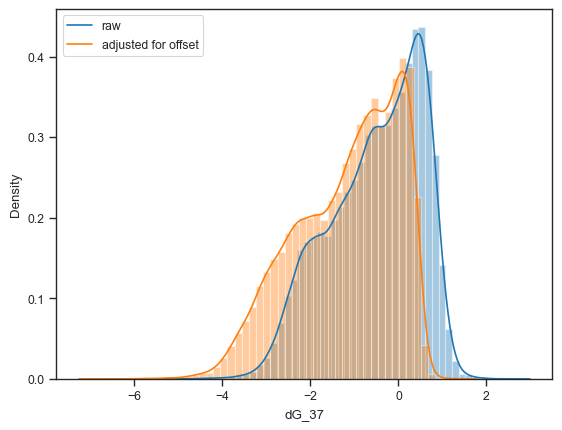

In [162]:
sns.distplot(arr.dG_37)
sns.distplot(arr_adj.dG_37)
plt.legend(['raw', 'adjusted for offset'])

## Salt correct array data to fucking 1M Na+

`arr_adj` -> `arr_1M`

In [163]:
%%time
param_names = ['dH','dS','Tm', 'dG_37']
arr_1M = pd.DataFrame(index=arr_adj.index, columns=param_names)

for i, row in arr_adj.iterrows():
    param_dict = util.get_Na_adjusted_param(Na=1.0, dH=row.dH, Tm=row.Tm, seq=row.RefSeq)
    arr_1M.loc[i,:] = param_dict

# cols = ['dH_se', 'Tm_se', 'dG_37_se', 'dS_se', 'RefSeq', 'TargetStruct', 'Series']
arr_1M[cols] = arr[cols]

arr_1M.dropna(subset=['RefSeq','TargetStruct'], inplace=True)

CPU times: user 5.94 s, sys: 91.3 ms, total: 6.03 s
Wall time: 5.97 s


In [240]:
# remove dangles
sd_mask = arr_1M.apply(lambda row: not row.name.startswith('SD'), axis=1)
arr_1M = arr_1M[sd_mask.values]

In [242]:
arr_1M.to_csv('./data/models/raw/arr_1M.csv')

In [243]:
arr_1M = pd.read_csv('./data/models/raw/arr_1M.csv', index_col=0)

## Fit parameters based on the 1M Na+ data

In [14]:
%%time
feats = mf.get_feature_count_matrix(arr_1M, feature_method='get_feature_list', 
                                    fit_intercept=False, symmetry=False, sep_base_stack=True)
print(feats.shape)

(30922, 1371)
CPU times: user 27 s, sys: 256 ms, total: 27.3 s
Wall time: 27.1 s


CPU times: user 7min 21s, sys: 5min 30s, total: 12min 51s
Wall time: 14min 37s


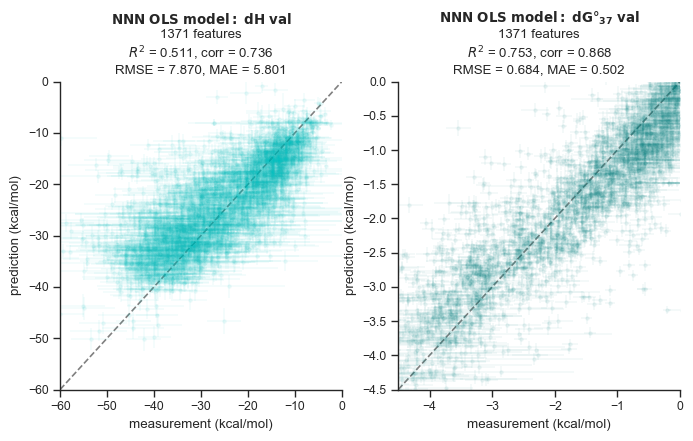

In [20]:
%%time 
fig, ax = plt.subplots(1, 2, figsize=(8,4))
lr_dH = mf.fit_param(arr_1M, data_split_dict, param='dH', feats=feats, ax=ax[0])
lr_dG = mf.fit_param(arr_1M, data_split_dict, param='dG_37', feats=feats, ax=ax[1])

In [21]:
fileio.write_pickle(lr_dH, './data/models/saved/lr_dH_v0.0.pkl')
fileio.write_pickle(lr_dG, './data/models/saved/lr_dG_v0.0.pkl')

In [22]:
def get_triloop_df(lr, param):
    triloop_param = lr.coef_df.loc[[x for x in lr.coef_df.index if x.endswith('_...')]]
    closing_param = lr.coef_df.loc[[x for x in lr.coef_df.index if (x.endswith('_(+)') and (not x.startswith('x')))]]

    triloop_list = []
    param_list = []
    for triloop in triloop_param.index:
        for closing in closing_param.index:
            closing_pair = closing.split('_')[0]
            full_triloop = closing_pair[0] + triloop.split('_')[0] + closing_pair[2]
            triloop_list.append(full_triloop)
            param_list.append(triloop_param.loc[triloop][0] + closing_param.loc[closing][0])

    triloop_df = pd.DataFrame(index = triloop_list, data=param_list, columns=[param])
    return triloop_df

In [148]:
triloop_dict_dH = get_triloop_df(lr_dH, 'dH').to_dict()
triloop_dict_dG = get_triloop_df(lr_dG, 'dG').to_dict()

In [24]:
param_set_file = './models/dna-nnn.json'

param_set_dict = fileio.read_json(param_set_file)
param_set_dict['dH']['hairpin_triloop'] = triloop_dict_dH['dH']
param_set_dict['dG']['hairpin_triloop'] = triloop_dict_dG['dG']

Figuring out if I need to adjust for the 3.5 kcal/mol for the triloop size specific parameters on top of the sequence parameters

In [33]:
for key in param_set_dict['dG']['hairpin_triloop']:
    param_set_dict['dG']['hairpin_triloop'][key]  -= param_set_dict['dG']['hairpin_size'][2]

Fine I just adjust for the offset directly

In [62]:
%%time
triloop_ind = [x for x in train_ind if x.startswith('TRI')]
triloop_ind = np.random.choice(triloop_ind, 100, replace=False)
pred = list(arr.loc[triloop_ind,:].apply(lambda row: util.get_nupack_dH_dS_Tm_dG_37(row.RefSeq, row.TargetStruct, sodium=0.088, return_dict=False, param_set='./models/dna-nnn.json'), axis=1))

CPU times: user 6.2 s, sys: 104 ms, total: 6.31 s
Wall time: 6.31 s


In [65]:
arr['dG_37_adj'] = arr_adj.dG_37
arr[['dH_MUPACK', 'dS_MUPACK', 'Tm_MUPACK', 'dG_37_MUPACK']] = np.nan
arr.loc[triloop_ind, ['dH_MUPACK', 'dS_MUPACK', 'Tm_MUPACK', 'dG_37_MUPACK']] = pred

In [70]:
ddG = arr.loc[triloop_ind, 'dG_37_adj'].median() - arr.loc[triloop_ind, 'dG_37_MUPACK'].median()

In [153]:
param_set_dict = fileio.read_json('./models/dna04.json')
param_set_dict['dH']['hairpin_triloop'] = triloop_dict_dH['dH'].copy()
param_set_dict['dG']['hairpin_triloop'] = triloop_dict_dG['dG'].copy()

for key in param_set_dict['dG']['hairpin_triloop']:
    param_set_dict['dG']['hairpin_triloop'][key]  += ddG

param_set_dict['dG']['hairpin_size'][2] = 3.5 + ddG    

fileio.write_json(param_set_dict, param_set_file)

Test on a random triloop hairpin:

In [155]:
seqid = 'TRINNN999'
seq = arr.loc[seqid, 'RefSeq']
struct = arr.loc[seqid, 'TargetStruct']

print('measured')
arr.loc[seqid, ['dH', 'dG_37', 'Tm']]#, uv_df.loc[seqid, 'dG_37_uv'], arr.loc[seqid, 'dH'], uv_df.loc[seqid, 'dH_uv']

measured


dH      -32.528352
dG_37    -1.802786
Tm       55.332972
Name: TRINNN999, dtype: object

In [156]:
print('original NUPACK')
util.get_nupack_dH_dS_Tm_dG_37(seq, struct, sodium=0.088, return_dict=True, param_set='dna04')

original NUPACK


{'dH': -39.59999999999999,
 'dS': -0.11912727609281279,
 'Tm': 59.26757302624287,
 'dG_37': -2.652675319814104}

In [157]:
print('updated NUPACK')
util.get_nupack_dH_dS_Tm_dG_37(seq, struct, sodium=0.088, return_dict=True, param_set=param_set_file)

updated NUPACK


{'dH': -42.98384737873516,
 'dS': -0.1341835367798519,
 'Tm': 47.18622313336829,
 'dG_37': -1.3668234464641036}

# Predict all

In [93]:
triloop_ind = [x for x in val_ind if x.startswith('TRI')]
triloop_ind = np.random.choice(triloop_ind, 100, replace=False)

In [158]:
%%time
pred = list(arr.loc[triloop_ind,:].apply(lambda row: util.get_nupack_dH_dS_Tm_dG_37(row.RefSeq, row.TargetStruct, sodium=0.088, return_dict=False, param_set='./models/dna-nnn.json'), axis=1))
# arr[['dH_MUPACK', 'dS_MUPACK', 'Tm_MUPACK', 'dG_37_MUPACK']] = pred

arr[['dH_MUPACK', 'dS_MUPACK', 'Tm_MUPACK', 'dG_37_MUPACK']] = np.nan
arr.loc[triloop_ind, ['dH_MUPACK', 'dS_MUPACK', 'Tm_MUPACK', 'dG_37_MUPACK']] = pred

CPU times: user 6.17 s, sys: 89.5 ms, total: 6.26 s
Wall time: 6.27 s


In [106]:
arr['Tm_adj'] = arr_adj.Tm

In [160]:
arr.dG_37_MUPACK += ddG

arr.Tm_MUPACK = util.get_Tm(arr.dH_MUPACK, arr.dG_37_MUPACK)

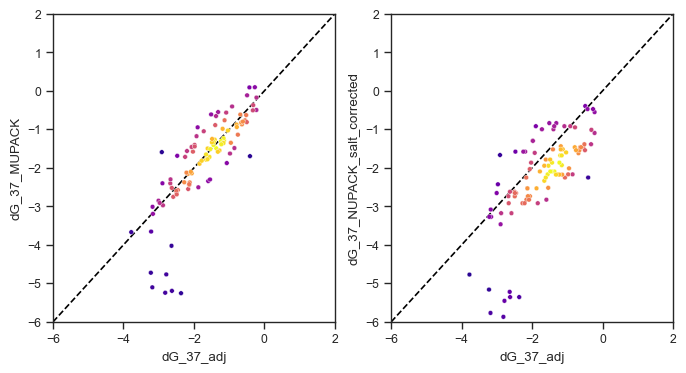

In [161]:
lim = [-6,2]
fig, ax = plt.subplots(1,2,figsize=(8,4))
plotting.plot_colored_scatter_comparison(data=arr.loc[triloop_ind], x='dG_37_adj', y='dG_37_MUPACK', 
                                         lim=lim, ax=ax[0], show_cbar=False)

plotting.plot_colored_scatter_comparison(data=arr.loc[triloop_ind], x='dG_37_adj', y='dG_37_NUPACK_salt_corrected', 
                                         lim=lim, ax=ax[1], show_cbar=False)


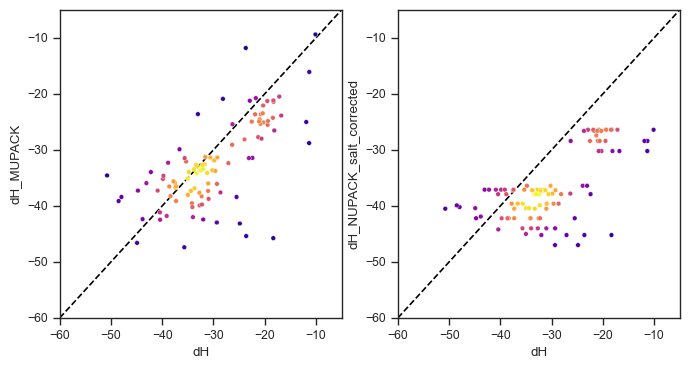

In [162]:
lim = [-60,-5]
fig, ax = plt.subplots(1,2,figsize=(8,4))
plotting.plot_colored_scatter_comparison(data=arr.loc[triloop_ind], x='dH', y='dH_MUPACK', 
                                         lim=lim, ax=ax[0], show_cbar=False)

plotting.plot_colored_scatter_comparison(data=arr.loc[triloop_ind], x='dH', y='dH_NUPACK_salt_corrected', 
                                         lim=lim, ax=ax[1], show_cbar=False)


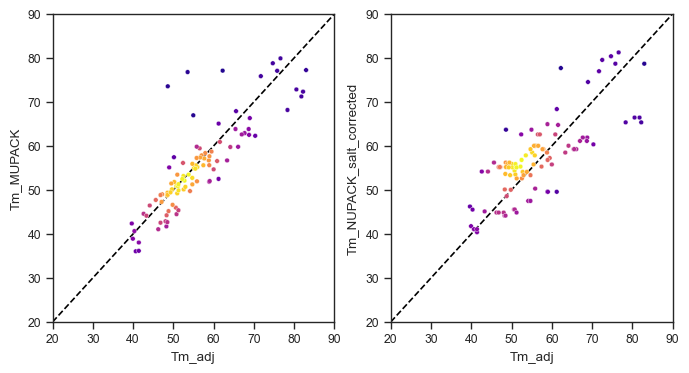

In [167]:
lim = [20,90]
fig, ax = plt.subplots(1,2,figsize=(8,4))
plotting.plot_colored_scatter_comparison(data=arr.loc[triloop_ind], x='Tm_adj', y='Tm_MUPACK', 
                                         lim=lim, ax=ax[0], show_cbar=False)

plotting.plot_colored_scatter_comparison(data=arr.loc[triloop_ind], x='Tm_adj', y='Tm_NUPACK_salt_corrected', 
                                         lim=lim, ax=ax[1], show_cbar=False)


I do see some improvements here.

# Look at UV triloops now

In [168]:
triloop_ind = [x for x in uv_df.index if x.startswith('TRI')]

In [170]:
%%time
pred = list(arr.loc[triloop_ind,:].apply(lambda row: util.get_nupack_dH_dS_Tm_dG_37(row.RefSeq, row.TargetStruct, sodium=0.088, return_dict=False, param_set='./models/dna-nnn.json'), axis=1))
# arr[['dH_MUPACK', 'dS_MUPACK', 'Tm_MUPACK', 'dG_37_MUPACK']] = pred

arr[['dH_MUPACK', 'dS_MUPACK', 'Tm_MUPACK', 'dG_37_MUPACK']] = np.nan
arr.loc[triloop_ind, ['dH_MUPACK', 'dS_MUPACK', 'Tm_MUPACK', 'dG_37_MUPACK']] = pred

arr.dG_37_MUPACK += ddG
arr.Tm_MUPACK = util.get_Tm(arr.dH_MUPACK, arr.dG_37_MUPACK)

CPU times: user 502 ms, sys: 8.98 ms, total: 511 ms
Wall time: 512 ms


In [192]:
cols = ['dG_37_uv', 'Tm_uv', 'dH_uv']
uv = uv_df.query('Na_mM == 25 & is_hairpin')[cols].groupby('SEQID').apply(np.mean)
arr[cols] = np.nan
arr.loc[triloop_ind, cols] = uv.loc[triloop_ind, cols]

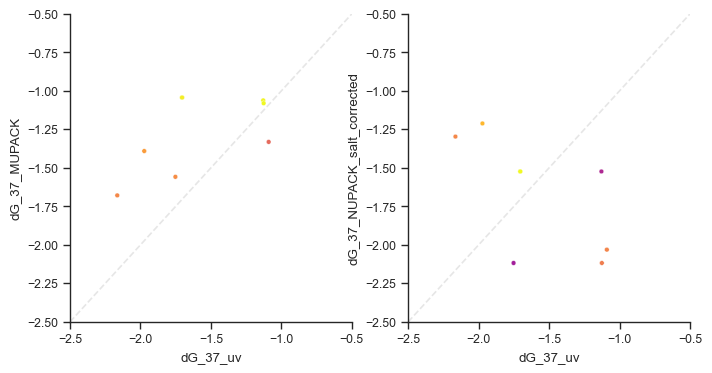

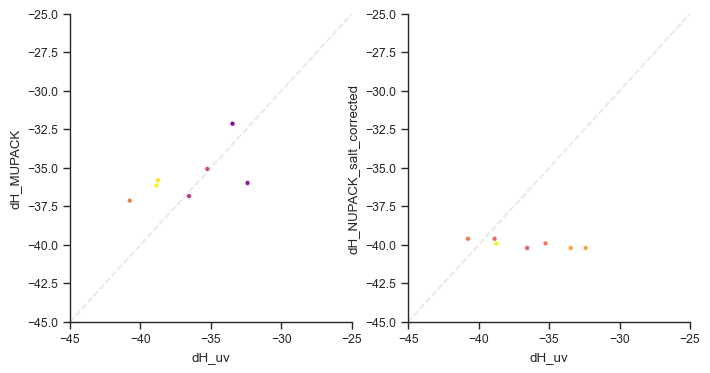

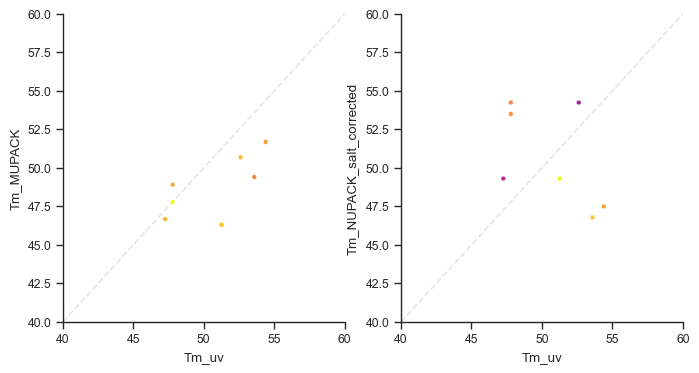

In [206]:
def plot_mupack_nupack(param, lim):
    fig, ax = plt.subplots(1,2,figsize=(8,4))
    plotting.plot_colored_scatter_comparison(data=arr.loc[triloop_ind], x=param+'_uv', y=param+'_MUPACK', 
                                             lim=lim, ax=ax[0], show_cbar=False)

    plotting.plot_colored_scatter_comparison(data=arr.loc[triloop_ind], x=param+'_uv', y=param+'_NUPACK_salt_corrected', 
                                             lim=lim, ax=ax[1], show_cbar=False)
    # plt.show()


plot_mupack_nupack('dG_37', [-2.5,-0.5])
plot_mupack_nupack('dH', [-45, -25])
plot_mupack_nupack('Tm', [40, 60])
util.save_multi_image('./fig/models/MUPACK/model_pred_vs_uv_v0.pdf')

# Take a closer look at the triloop parameters

Can we further reduce the number of parameters?

## Silly UMAP for fun

In [223]:
from src.models import knn
import umap

In [213]:
p_dict = param_set_dict['dG']['hairpin_triloop']

In [220]:
dist_mat = knn.compute_edit_distance(p_dict.keys(), p_dict.keys())

256it [00:00, 8734.72it/s]


In [221]:
dist_mat

array([[0, 2, 2, ..., 5, 5, 5],
       [2, 0, 2, ..., 3, 5, 5],
       [2, 2, 0, ..., 5, 3, 5],
       ...,
       [5, 3, 5, ..., 0, 2, 2],
       [5, 5, 3, ..., 2, 0, 2],
       [5, 5, 5, ..., 2, 2, 0]])

In [236]:
%%time
np.random.seed(42)
embedding = umap.UMAP(n_neighbors=3,
                      min_dist=1,
                      metric='euclidean').fit_transform(dist_mat)

CPU times: user 1.23 s, sys: 42.1 ms, total: 1.27 s
Wall time: 1.03 s


In [237]:
p_df = pd.DataFrame(data=p_dict, index=['dG']).T
p_df[['UMAP_1', 'UMAP_2']]= embedding

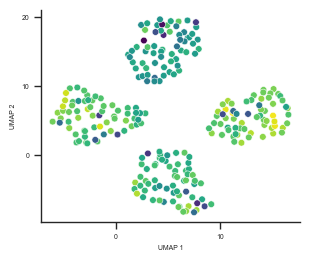

In [239]:
fig, ax = plt.subplots(figsize=(2*4.25*cm, 2*3.5*cm))
sns.scatterplot(data=p_df, x='UMAP_1', y='UMAP_2', hue='dG', 
                alpha=0.99, palette='viridis',
                rasterized=True)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(10))

ax.set_yticklabels(ax.get_yticklabels(), fontsize=tick_font_size)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=tick_font_size)

ax.set_xlabel('UMAP 1', fontsize=tick_font_size)
ax.set_ylabel('UMAP 2', fontsize=tick_font_size)
ax.get_legend().remove()
sns.despine()

(array([ 2304.,  8872., 17568., 25288., 11248.,     0.]),
 array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 <BarContainer object of 6 artists>)

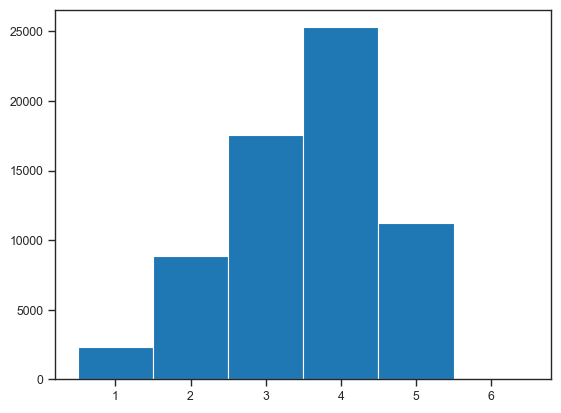

In [242]:
plt.hist(dist_mat.flatten(), bins=np.arange(.5,7.5))

## Dictionary learining example

In [1]:
import numpy as np
from sklearn.datasets import make_sparse_coded_signal
from sklearn.decomposition import DictionaryLearning
X, dictionary, code = make_sparse_coded_signal(
    n_samples=100, n_components=15, n_features=20, n_nonzero_coefs=10,
    random_state=42, data_transposed=False
)
dict_learner = DictionaryLearning(
    n_components=15, transform_algorithm='lasso_lars', transform_alpha=0.1,
    random_state=42,
)
X_transformed = dict_learner.fit_transform(X)

In [6]:
X.shape, dictionary.shape, code.shape

((100, 20), (15, 20), (100, 15))

In [9]:
X_transformed.shape

(100, 15)

In [10]:
np.mean(X_transformed == 0)

0.41733333333333333

In [11]:
X_hat = X_transformed @ dict_learner.components_

In [14]:
np.mean(np.sum((X_hat - X) ** 2, axis=1) / np.sum(X ** 2, axis=1))

0.07777084613290736

## Apply dictionary learning to triloop parameters

In [ ]:
import numpy as np
from sklearn.datasets import make_sparse_coded_signal
from sklearn.decomposition import DictionaryLearning

In [36]:
def onehot_nucleotide(seq_str):
    map_dict = dict(A=0, T=1, C=2, G=3)
    N = len(seq_str)
    encode_arr = np.zeros((N, 4))
    for i,x in enumerate(seq_str.upper()):
        encode_arr[i, map_dict[x]] = 1
    return encode_arr

In [21]:
"""
Enumerate all possible triloops and one-hot encode
"""
from scripts.make_lib3 import *

loops = def_triloops()
pairs = def_pairs()

triloops = []
for loop in loops:
    triloops += add_loop_2_seqs(loop, pairs)

X = np.array([onehot_nucleotide(triloop).flatten() for triloop in triloops])
X.shape

### One model

In [54]:
%%time
dict_learner = DictionaryLearning(
    n_components=10, transform_algorithm='lasso_lars', transform_alpha=0.1,
    random_state=42,
)
X_transformed = dict_learner.fit_transform(X)

CPU times: user 5 s, sys: 920 ms, total: 5.92 s
Wall time: 4.83 s


In [55]:
np.mean(X == 0), np.mean(X_transformed == 0)

(0.75, 0.3083984375)

In [56]:
X_hat = X_transformed @ dict_learner.components_
np.mean(np.sum((X_hat - X) ** 2, axis=1) / np.sum(X ** 2, axis=1))

0.3781159065112989

### Parameter sweep

In [81]:
%%time
"""
Find a good n_components
"""
psweep = np.arange(14,19)
sparsity, rmse = np.zeros(len(psweep)), np.zeros(len(psweep))
for i,n_components in enumerate(psweep):
    dict_learner = DictionaryLearning(
        n_components=n_components, transform_algorithm='lasso_lars', transform_alpha=0.01,
        random_state=42,
    )
    X_transformed = dict_learner.fit_transform(X)
    sparsity[i] = np.mean(X_transformed == 0)
    X_hat = X_transformed @ dict_learner.components_
    rmse[i] = np.mean(np.sum((X_hat - X) ** 2, axis=1) / np.sum(X ** 2, axis=1))

CPU times: user 1min 40s, sys: 2min 56s, total: 4min 36s
Wall time: 1min


(0.0, 0.10492250360873222)

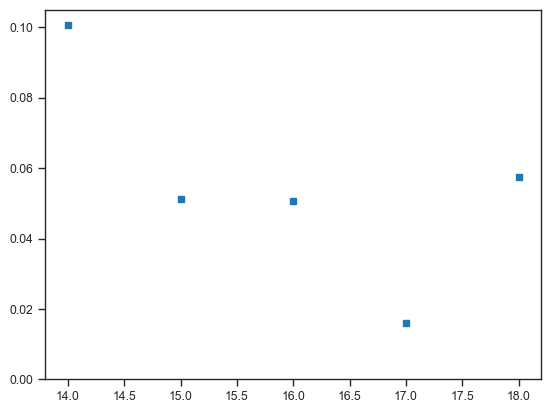

In [82]:
plt.plot(psweep, rmse, 's')
plt.ylim(bottom=0)

(0.0, 0.22292364211309523)

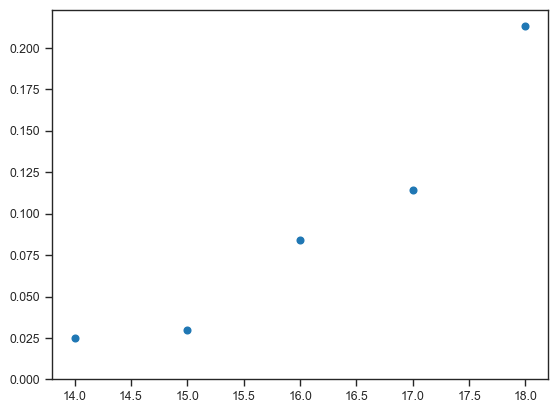

In [83]:
plt.plot(psweep, sparsity, 'o')
plt.ylim(bottom=0)

I'll just take 17 dims. Good enough.

Next I'll implement it in the feature extractor.

## to `feature_list`

First fit and save the chosen model

In [84]:
%%time
dict_learner = DictionaryLearning(
    n_components=17, transform_algorithm='lasso_lars', transform_alpha=0.01,
    random_state=42,
)
X_transformed = dict_learner.fit_transform(X)

CPU times: user 27 s, sys: 47.3 s, total: 1min 14s
Wall time: 15.9 s


In [85]:
fileio.write_pickle(dict_learner, './data/models/saved/triloop_dict_learner.pkl')

In [101]:
param_set_file = './models/dna-nnn.json'
param_set_dict = fileio.read_json(param_set_file)

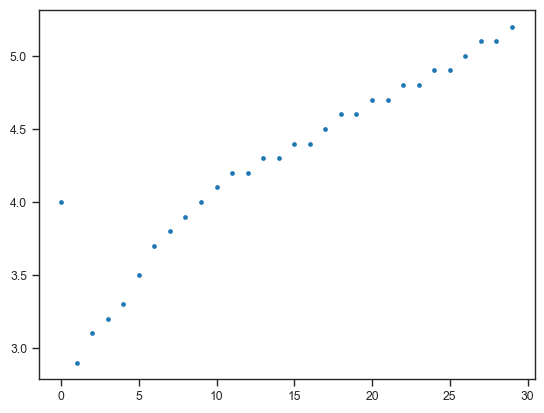

In [104]:
plt.plot(param_set_dict['dG']['bulge_size'], '.')

### Test `get_nupack_feature_list`

In [105]:
from RiboGraphViz import LoopExtruder, StackExtruder
from nnn import feature_list

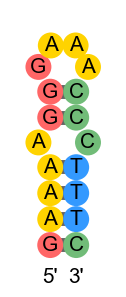

['interior_size$2',
 'interior_mismatch$CTAA',
 'interior_mismatch$AGCC',
 'hairpin_size$4',
 'hairpin_tetraloop$GGAAAC',
 'stack$AATT',
 'stack$AATT',
 'stack$GATC',
 'terminal_penalty$GC',
 'stack$GGCC']

In [195]:
seqid = 'MMACP10'
seq = arr.loc[seqid, 'RefSeq']
struct = arr.loc[seqid, 'TargetStruct']
draw_struct(seq, struct)
feature_list.get_nupack_feature_list(arr.loc[seqid])

### Extract all nupack features

In [358]:
arr_1M = pd.read_csv('./data/models/raw/arr_1M.csv', index_col=0)
data_split_dict = fileio.read_json('./data/models/raw/data_split.json')

In [359]:
%%time
feats = mf.get_feature_count_matrix(arr_1M, feature_method='get_nupack_feature_list', 
                                    feature_style='nupack', fit_intercept=False)
print(feats.shape)
print(np.linalg.matrix_rank(feats))
feats

(30853, 180)
177
CPU times: user 16.2 s, sys: 2.4 s, total: 18.6 s
Wall time: 15 s


,bulge_size#1,bulge_size#2,hairpin_mismatch#AATA,hairpin_mismatch#AATC,hairpin_mismatch#AATG,hairpin_mismatch#AATT,hairpin_mismatch#ACGA,hairpin_mismatch#ACGC,hairpin_mismatch#ACGG,hairpin_mismatch#ACGT,...,stack#GGCC,stack#GTAC,stack#TATA,stack#TCGA,stack#TGCA,stack#TTAA,terminal_penalty#AT,terminal_penalty#CG,terminal_penalty#GC,terminal_penalty#TA
SEQID,,,,,,,,,,,,,,,,,,,,,
BC0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
BC1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
BC10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
BC11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
BC15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
varloop257601,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
varloop257621,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
varloop257641,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [360]:
np.linalg.matrix_rank(feats.values)

177

In [310]:
import sympy

In [361]:
%%time
feats_mat = sympy.Matrix(feats.values)

CPU times: user 27.1 s, sys: 94.4 ms, total: 27.2 s
Wall time: 27.2 s


In [362]:
feats_mat.shape

(30853, 180)

In [363]:
%%time
# find linearly independent rows
_, inds= feats_mat.rref()
# inds

CPU times: user 3min 13s, sys: 817 ms, total: 3min 14s
Wall time: 3min 14s


In [364]:
indep_feats = feats.columns[np.array(inds, dtype=int)]

In [365]:
set(feats.columns) - set(indep_feats)

{'hairpin_tetraloop#TG', 'hairpin_triloop#G', 'interior_size#4'}

CPU times: user 16.7 s, sys: 23.7 s, total: 40.5 s
Wall time: 25 s


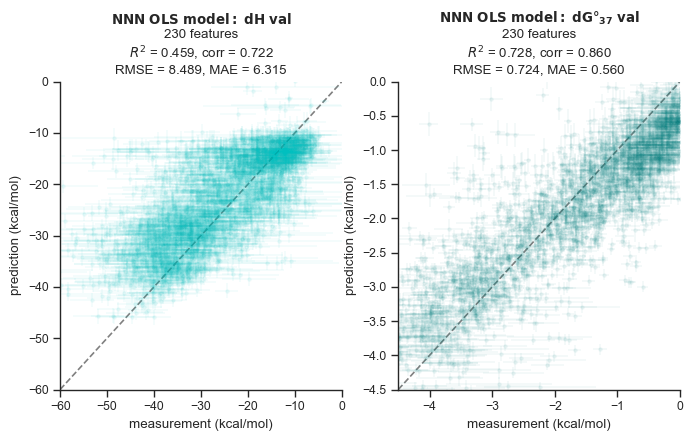

In [290]:
%%time 
fig, ax = plt.subplots(1, 2, figsize=(8,4))
lr_dH = mf.fit_param(arr_1M, data_split_dict, param='dH', feats=feats, ax=ax[0])
lr_dG = mf.fit_param(arr_1M, data_split_dict, param='dG_37', feats=feats, ax=ax[1])

This is worse than my parameterization. At least for dH. dG is similar.

(array([  1.,   0.,   3.,   7.,  12.,  54., 273., 160.,  15.,   5.]),
 array([-37.25473194, -31.82218879, -26.38964565, -20.95710251,
        -15.52455937, -10.09201622,  -4.65947308,   0.77307006,
          6.20561321,  11.63815635,  17.07069949]),
 <BarContainer object of 10 artists>)

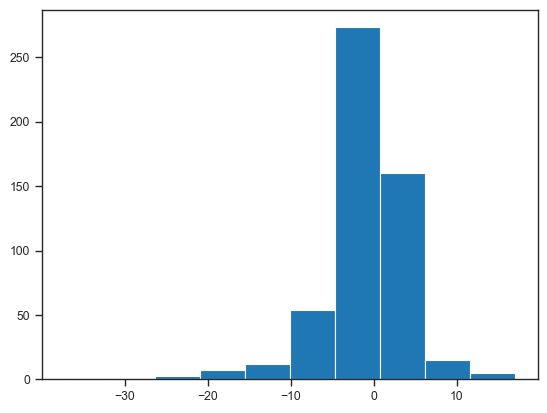

In [262]:
plt.hist(lr_dH.coef_)

In [277]:
len(lr_dG.coef_df.query('dG_37 < 1e-2 and dG_37 > -1e-2')) / len(lr_dG.coef_)

0.009433962264150943

In [352]:
lr_dG.coef_df.loc['hairpin_tetraloop#TT']

dG_37   -0.271012
Name: hairpin_tetraloop#TT, dtype: float64

(array([ 2., 64., 26., 16.,  4., 48.,  2., 16., 48.,  4.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

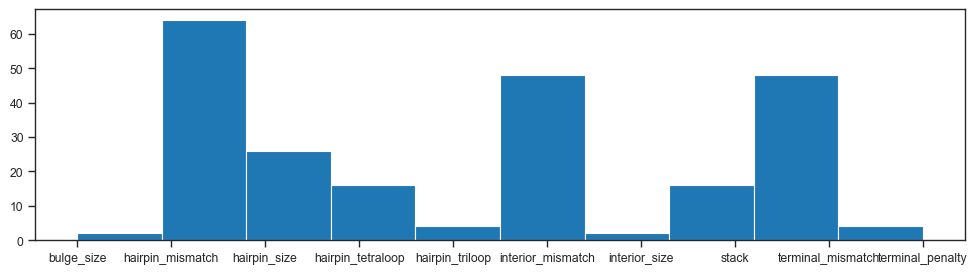

In [292]:
plt.figure(figsize=(12,3))
plt.hist([x.split('#')[0] for x in feats.columns])

### Only fit a subset of parameters

In [418]:
param_set_dict = fileio.read_json('./models/dna04.json')

In [452]:
mupack.coef_dict_2_df(param_set_dict['dH'])

,value
bulge_size#1,0.0
bulge_size#2,0.0
bulge_size#3,0.0
bulge_size#4,0.0
bulge_size#5,0.0
...,...
terminal_mismatch#TTAT,-4.0
terminal_mismatch#TTGA,-0.3
terminal_mismatch#TTGC,-0.3
terminal_mismatch#TTGG,-0.3


### Convert fitted parameters to the json file.

> Note that mismatches are kept in a lookup table calculated from the fitted terminal or interior mm parameters.

In [421]:
from nnn import mupack

In [412]:
dG_dict = mupack.coef_df_2_dict(lr_dG.coef_df)

In [366]:
param_set_dict = fileio.read_json('./models/dna04.json')
# param_set_dict['dH']['hairpin_triloop'] = triloop_dict_dH['dH'].copy()
# param_set_dict['dG']['hairpin_triloop'] = triloop_dict_dG['dG'].copy()

In [430]:
dG_df = mupack.coef_dict_2_df(dG_dict)

# 05/18/2023

In [75]:
%%time
feats = mf.get_feature_count_matrix(arr_1M, feature_method='get_feature_list', 
                                    fit_intercept=False, symmetry=False, sep_base_stack=True)
print(feats.shape)

(29863, 1340)
CPU times: user 20 s, sys: 136 ms, total: 20.1 s
Wall time: 20.1 s


CPU times: user 2min 32s, sys: 2min 7s, total: 4min 40s
Wall time: 1min 3s


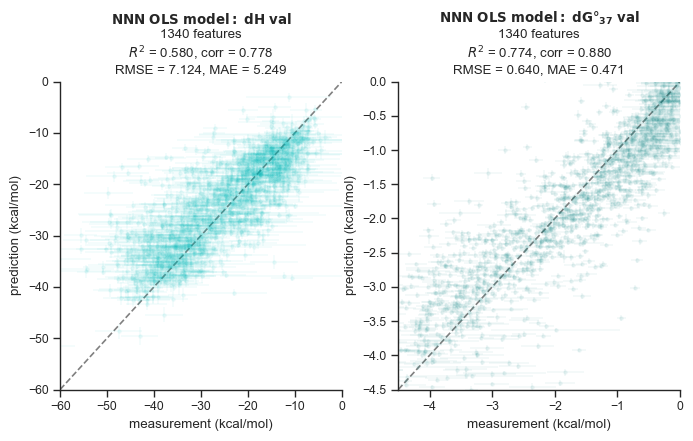

In [76]:
%%time 
fig, ax = plt.subplots(1, 2, figsize=(8,4))
lr_dH = mf.fit_param(arr_1M, data_split_dict, param='dH', feats=feats, ax=ax[0])
lr_dG = mf.fit_param(arr_1M, data_split_dict, param='dG_37', feats=feats, ax=ax[1])

In [78]:
%%time
feats = mf.get_feature_count_matrix(arr_1M, feature_method='get_feature_list', 
                                    fit_intercept=False, symmetry=False, sep_base_stack=True, hairpin_mm=True)
print(feats.shape)

(29863, 1376)
CPU times: user 20.1 s, sys: 270 ms, total: 20.4 s
Wall time: 20.6 s


CPU times: user 2min 39s, sys: 2min 12s, total: 4min 51s
Wall time: 1min 6s


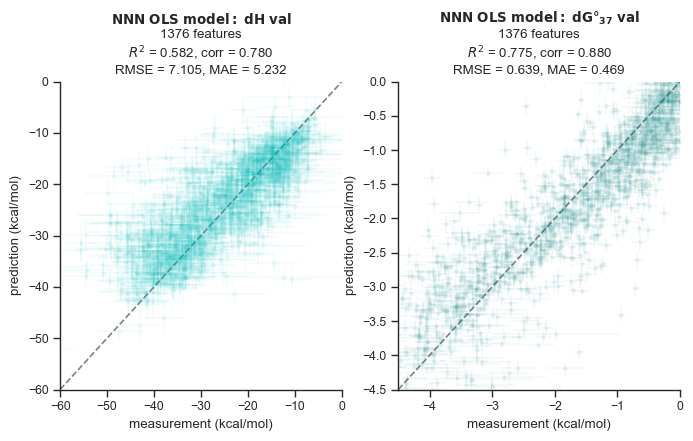

In [79]:
%%time 
# with hairpin mismatch parameters sep at 5' and 3'
fig, ax = plt.subplots(1, 2, figsize=(8,4))
lr_dH = mf.fit_param(arr_1M, data_split_dict, param='dH', feats=feats, ax=ax[0])
lr_dG = mf.fit_param(arr_1M, data_split_dict, param='dG_37', feats=feats, ax=ax[1])

In [ ]:
%%time
# with one single nupack-style hairpin mismatch
feats = mf.get_feature_count_matrix(arr_1M, feature_method='get_feature_list', 
                                    fit_intercept=False, symmetry=False, sep_base_stack=True, hairpin_mm=True, ignore_base_stack=True)
print(feats.shape)


fig, ax = plt.subplots(1, 2, figsize=(8,4))
lr_dH = mf.fit_param(arr_1M, data_split_dict, param='dH', feats=feats, ax=ax[0])
lr_dG = mf.fit_param(arr_1M, data_split_dict, param='dG_37', feats=feats, ax=ax[1])

(29863, 1401)


# 06/02/2023

In [5]:
e348_df = pd.read_table('./data/external/Compiled_DNA_Tm_Data - 348oligos.csv', sep=',').drop(columns=['S. No.']).rename(
    columns={'Oligonucleotide Sequence' : 'seq', 'Exp. Tm (°C)' : 'Tm', 'Salt Conc. (M)' : 'sodium', 'DNA Conc. (M)' : 'DNA_conc'})

def ss2ds(ss):
    rs = util.rcompliment(ss)
    return ss + ' ' + rs

def len2struct(l):
    return '('*l+'+'+')'*l

e348_df['RefSeq'] = [ss2ds(x) for x in e348_df['seq']]
e348_df['rev'] = [util.rcompliment(x) for x in e348_df['seq']]
e348_df['TargetStruct'] = [len2struct(x) for x in e348_df['Length (bp)']]

In [6]:
e348_df.to_csv('./data/external/compiled_DNA_Tm_348oligos.csv')

In [7]:
e348_df

,Length (bp),sodium,DNA_conc,seq,Tm,Predicted Tm (°C),RefSeq,rev,TargetStruct
0,16,0.12,0.000005,AAAAAAAGCTTTTTTT,44.0,42.16,AAAAAAAGCTTTTTTT AAAAAAAGCTTTTTTT,AAAAAAAGCTTTTTTT,((((((((((((((((+))))))))))))))))
1,16,0.12,0.000007,AACGTGAATTCTGGCA,58.3,57.21,AACGTGAATTCTGGCA TGCCAGAATTCACGTT,TGCCAGAATTCACGTT,((((((((((((((((+))))))))))))))))
2,16,1.00,0.000018,CAACTTGATATTAATA,52.0,55.66,CAACTTGATATTAATA TATTAATATCAAGTTG,TATTAATATCAAGTTG,((((((((((((((((+))))))))))))))))
3,16,1.00,0.000100,CATATTGGCCAATATG,65.3,64.53,CATATTGGCCAATATG CATATTGGCCAATATG,CATATTGGCCAATATG,((((((((((((((((+))))))))))))))))
4,17,0.10,0.000004,CTCGTACCTTCCGGTCC,60.6,63.05,CTCGTACCTTCCGGTCC GGACCGGAAGGTACGAG,GGACCGGAAGGTACGAG,(((((((((((((((((+)))))))))))))))))
...,...,...,...,...,...,...,...,...,...
343,30,0.12,0.000002,GCCCCTCCACTGGCCGACGGCAGCAGGCTC,79.8,81.19,GCCCCTCCACTGGCCGACGGCAGCAGGCTC GAGCCTGCTGCCGTC...,GAGCCTGCTGCCGTCGGCCAGTGGAGGGGC,((((((((((((((((((((((((((((((+)))))))))))))))...
344,30,0.22,0.000002,GCCCCTCCACTGGCCGACGGCAGCAGGCTC,83.6,84.19,GCCCCTCCACTGGCCGACGGCAGCAGGCTC GAGCCTGCTGCCGTC...,GAGCCTGCTGCCGTCGGCCAGTGGAGGGGC,((((((((((((((((((((((((((((((+)))))))))))))))...
345,30,0.62,0.000002,GCCCCTCCACTGGCCGACGGCAGCAGGCTC,87.1,89.33,GCCCCTCCACTGGCCGACGGCAGCAGGCTC GAGCCTGCTGCCGTC...,GAGCCTGCTGCCGTCGGCCAGTGGAGGGGC,((((((((((((((((((((((((((((((+)))))))))))))))...
346,30,1.02,0.000002,GCCCCTCCACTGGCCGACGGCAGCAGGCTC,87.7,91.80,GCCCCTCCACTGGCCGACGGCAGCAGGCTC GAGCCTGCTGCCGTC...,GAGCCTGCTGCCGTCGGCCAGTGGAGGGGC,((((((((((((((((((((((((((((((+)))))))))))))))...


In [17]:
from tqdm import tqdm

In [36]:
Tms = np.zeros(len(e348_df))
dHs = np.zeros(len(e348_df))
dSs = np.zeros(len(e348_df))
for i,row in tqdm(e348_df.iterrows()):
    result = util.get_nupack_dH_dS_Tm_dG_37([row.seq, row.rev], row.TargetStruct, sodium=row.sodium, return_dict=True, param_set='dna04', ensemble='nostacking')
    Tms[i] = result['Tm']
    dHs[i] = result['dH']
    dSs[i] = result['dS']

348it [00:16, 21.48it/s]


In [52]:
R = 1.987
e348_df['Tm_pred'] = Tms

<Axes: xlabel='Tm', ylabel='Tm_pred'>

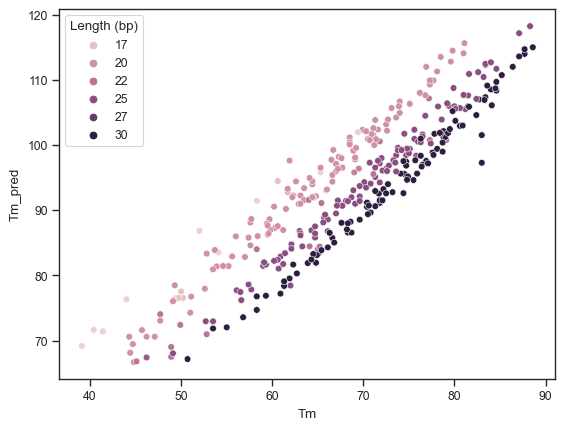

In [53]:
fig, ax = plt.subplots()
sns.scatterplot(data=e348_df, x='Tm', y='Tm_pred', ax=ax, hue='Length (bp)')
# plt.xlim([40,120])
# plt.ylim([40,120])

In [7]:
row = e348_df.iloc[0,:]
A = nupack.Strand(row.seq, name='A')
B = nupack.Strand(util.rcompliment(row.seq), name='B')
# c1 = nupack.Complex([A, B])
mytube = nupack.Tube(strands={A: row.DNA_conc, B: row.DNA_conc}, complexes=nupack.SetSpec(max_size=2), name='mytube')

mymodel = nupack.Model(material='dna', celsius=99, sodium=row.sodium, magnesium=0.0)
tube_results = nupack.tube_analysis(tubes=[mytube], model=mymodel)

tube_results

Complex,Pfunc,ΔG (kcal/mol)
(A),3.3215e+0,-0.888
(B),3.3215e+0,-0.888
(A+A),4.4274e+4,-7.912
(A+B),8.8548e+4,-8.424
(B+B),4.4274e+4,-7.912
Complex,mytube (M),
(B),4.992e-06,
(A),4.992e-06,
(A+B),3.759e-09,
(B+B),1.879e-09,


In [117]:
util.get_nupack_dH_dS_Tm_dG_37([row.seq, row.rev], row.TargetStruct, sodium=row.sodium, return_dict=False, param_set='./models/dna-nnn-hairpin.json')[2]


114.98034689292751

# 06/07/2023

Quickly checking if WC2318 UV melt matches the array data. The answer is yes.

In [16]:
arr = pd.read_csv('./data/models/raw/arr_v1_n=27732.csv', index_col=0)
arr_1M = pd.read_csv('./data/models/processed/arr_v1_1M_n=27732.csv', index_col=0)
agg_result_file='./data/uv_melt/uvmelt_agg_230502.csv'
uv_df = pd.read_csv(agg_result_file, index_col=1)

In [17]:
uv_df.loc['WC2318']

,Unnamed: 0,curve_date,curve_num,dH_uv,dH_uv_std,n_curve,Tm_uv,Tm_uv_std,dG_37_uv,dG_37_uv_std,dS_uv,dS_uv_std,is_hairpin,Na_mM,conc_uM,Purification
SEQID,,,,,,,,,,,,,,,,
WC2318,101,22071204,5,-50.300247,2.275660,3,70.226822,1.360676,-4.867298,3.071797,-0.146487,0.006653,True,1000.0,8.0,standard desalting
WC2318,102,22071204,6,-51.787338,0.528391,2,68.571182,0.078297,-4.784566,0.713656,-0.151549,0.001547,True,1000.0,4.0,standard desalting
WC2318,103,22071204,7,-48.732218,2.009607,4,69.243287,1.346107,-4.589129,2.717050,-0.142328,0.005896,True,1000.0,2.0,standard desalting


In [39]:
annotation_file = './data/annotation/NNNlib2b_annotation_20220519.tsv'
annotation = fileio.read_annotation(annotation_file, sodium=0.083)
replicate_df = pd.read_table('./data/nnnlib2b_replicates.tsv')

arraydata = ArrayData(replicate_df=replicate_df.iloc[:4,:],
                    annotation_file=annotation_file, )

86.43% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
78.88% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
64.31% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
71.46% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5


In [40]:
arraydata.celsius

{'r1': array([20. , 22.5, 25. , 27.5, 30. , 32.5, 35. , 37.5, 40. , 42.5, 45. ,
        47.5, 50. , 52.5, 55. , 57.5, 60. ]),
 'r2': array([20. , 22.5, 25. , 27.5, 30. , 32.5, 35. , 37.5, 40. , 42.5, 45. ,
        47.5, 50. , 52.5, 55. , 57.5, 60. ]),
 'r3': array([20. , 22.5, 25. , 27.5, 30. , 32.5, 35. , 37.5, 40. , 42.5, 45. ,
        47.5, 50. , 52.5, 55. , 57.5]),
 'rev': array([25. , 27.5, 30. , 32.5, 35. , 37.5, 40. , 42.5, 45. , 47.5, 50. ,
        52.5, 55. , 57.5, 60. , 20. ])}

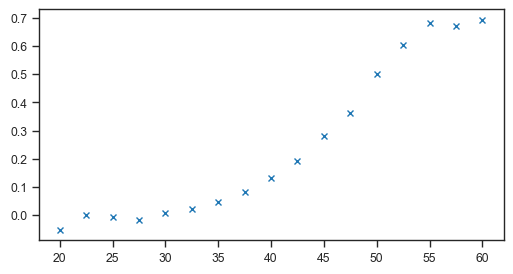

In [45]:
plt.figure(figsize=(6,3))
rep = 'r2'
plt.plot(arraydata.celsius[rep], arraydata.curve[rep].loc['WC2318'], 'x')

In [43]:
uv_df.loc['WC2318']

,Unnamed: 0,curve_date,curve_num,dH_uv,dH_uv_std,n_curve,Tm_uv,Tm_uv_std,dG_37_uv,dG_37_uv_std,dS_uv,dS_uv_std,is_hairpin,Na_mM,conc_uM,Purification
SEQID,,,,,,,,,,,,,,,,
WC2318,101,22071204,5,-50.300247,2.275660,3,70.226822,1.360676,-4.867298,3.071797,-0.146487,0.006653,True,1000.0,8.0,standard desalting
WC2318,102,22071204,6,-51.787338,0.528391,2,68.571182,0.078297,-4.784566,0.713656,-0.151549,0.001547,True,1000.0,4.0,standard desalting
WC2318,103,22071204,7,-48.732218,2.009607,4,69.243287,1.346107,-4.589129,2.717050,-0.142328,0.005896,True,1000.0,2.0,standard desalting


In [49]:
model

<function __main__.<lambda>(T, na)>

In [50]:
result[mytube]

NameError: name 'result' is not defined

In [56]:
np.unique(arraydata.data['Series'])

KeyError: 'Series'

# 06/08/2023

In [61]:
np.unique(arraydata.annotation.ConstructType)

array(['3mer', 'AC_mismatch_varpos', 'BaeControls', 'Centered',
       'GT_mismatch_varpos', 'NN', 'NNN', 'NNN_3primebulge',
       'NNN_5prime_bulge', 'NN_3primebulge', 'NN_5primebulge',
       'PUMcontrols', 'PolyNTControls', 'RepeatControls', 'StemDangle_3p',
       'StemDangle_53p', 'StemDangle_5p', 'SuperStem', 'VARloop',
       'VariableLoops', 'WBcontrols', 'WC_5ntstem', 'WC_6ntstem',
       'WC_7ntstem', 'pseudoknot_pt_muts', 'pseudoknots', 'ssfluor'],
      dtype=object)

In [86]:
df = arraydata.data.join(arraydata.annotation)

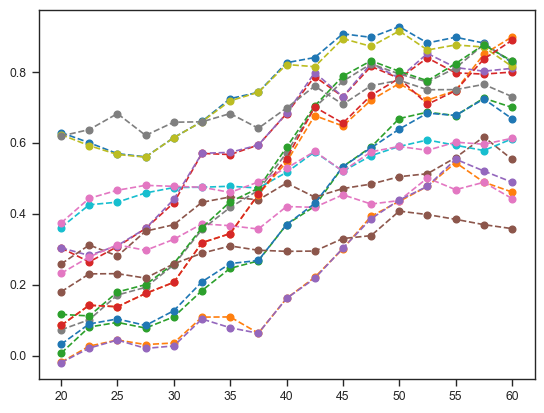

In [81]:
poly_id = df.query('ConstructType == "PolyNTControls"').sort_values(by='RefSeq').index

rep = 'r1'
ind = set(poly_id) & set(arraydata.curve[rep].index)
poly_curve = arraydata.curve[rep].loc[ind]

for i,row in poly_curve.iterrows():
    plt.plot(arraydata.celsius[rep], row.values, 'o--')

In [90]:
poly_seq = poly_curve.join(arraydata.annotation[['RefSeq']]).RefSeq

In [92]:
poly_len = [len(x) for x in poly_seq]

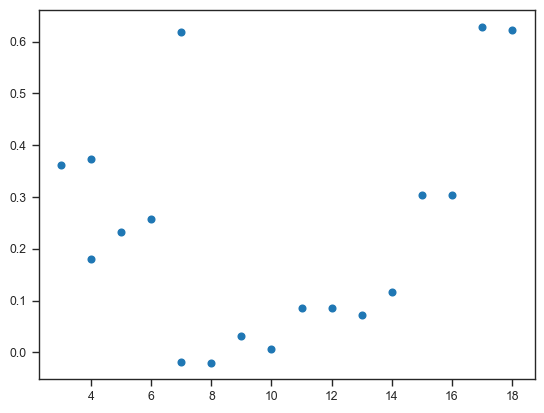

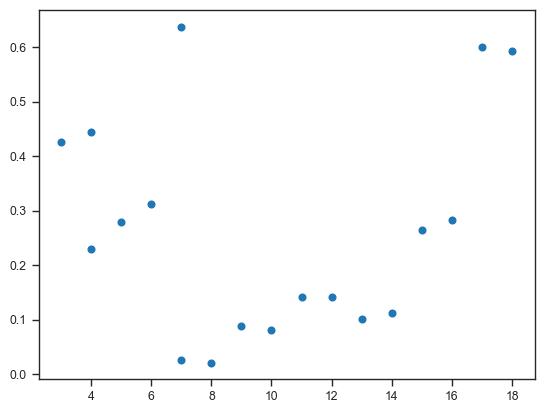

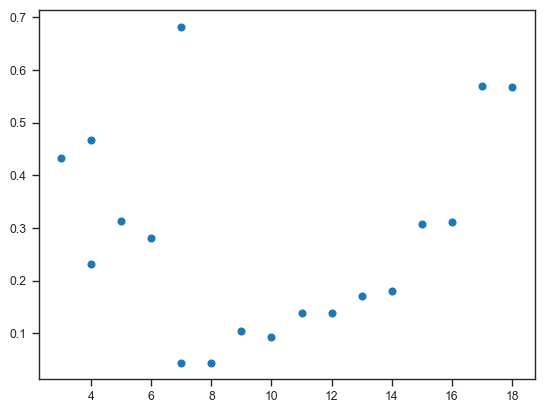

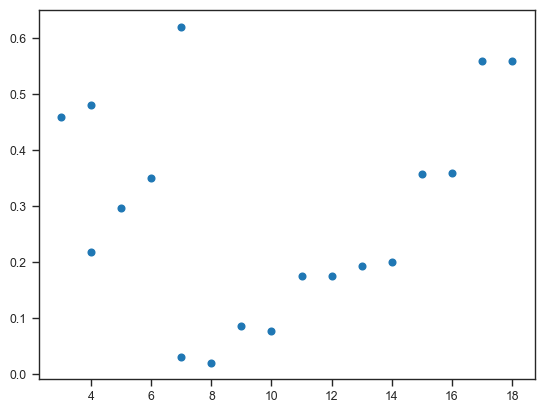

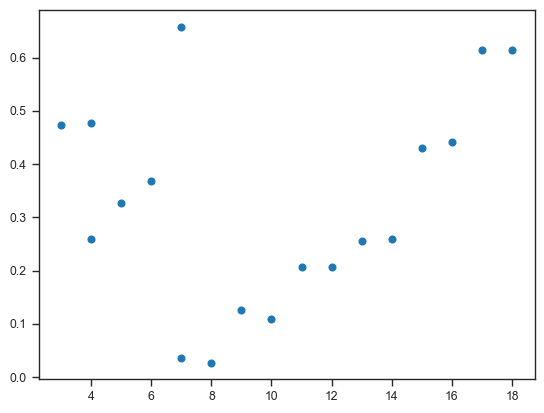

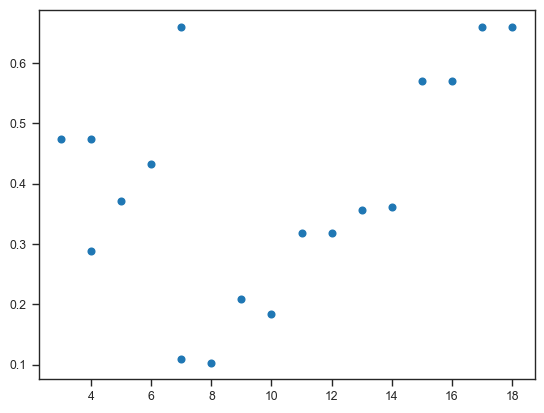

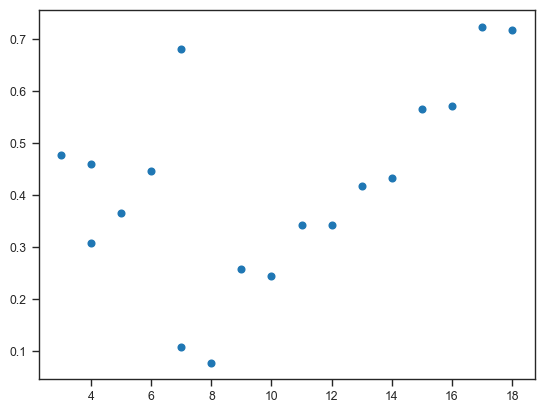

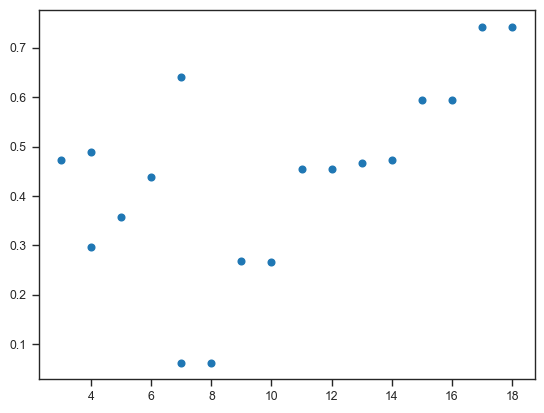

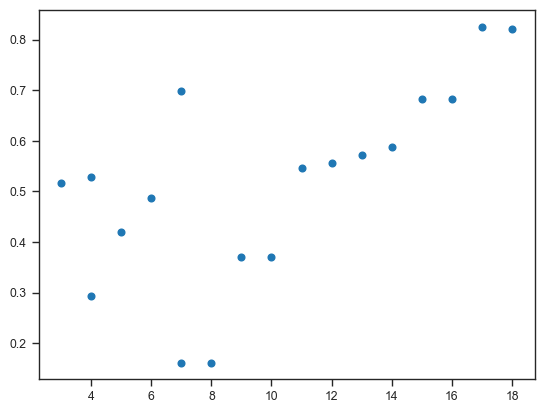

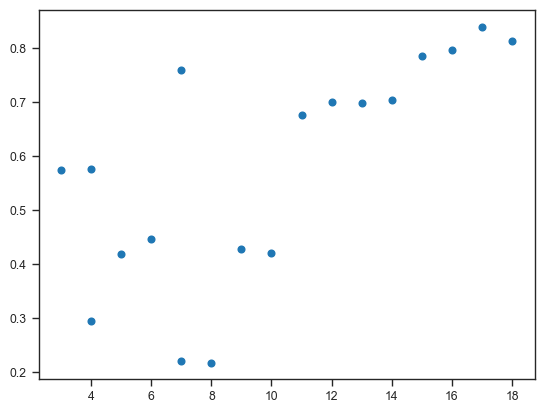

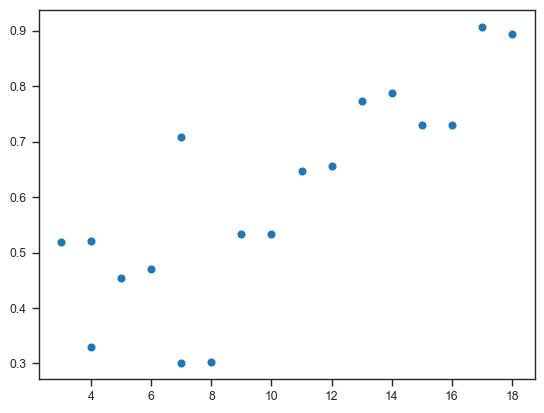

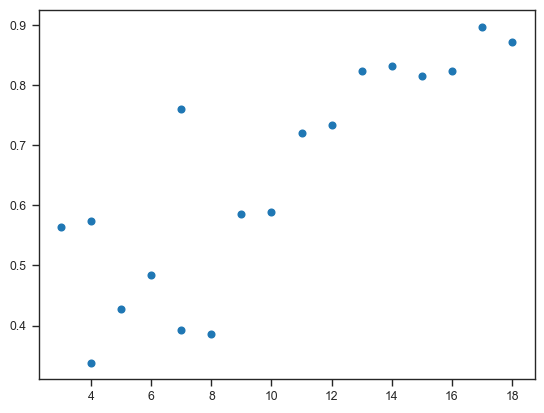

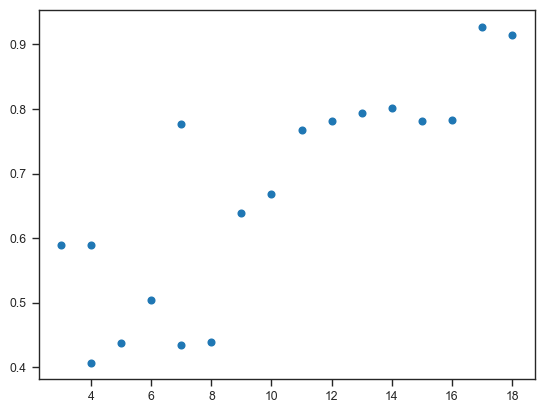

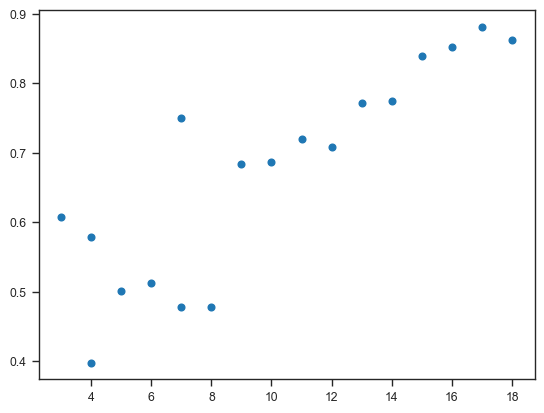

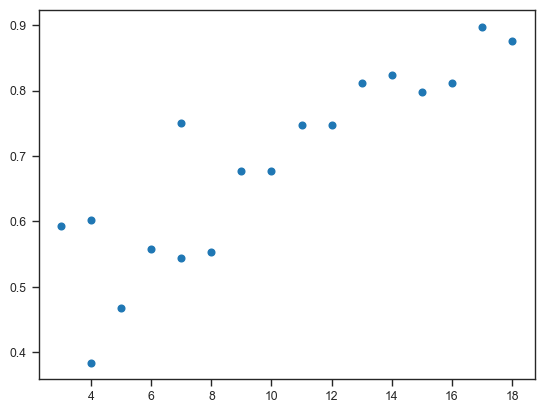

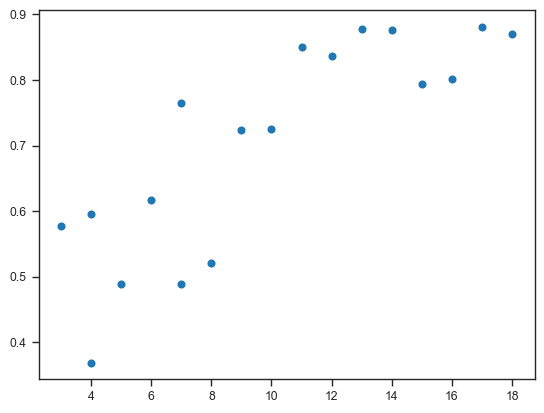

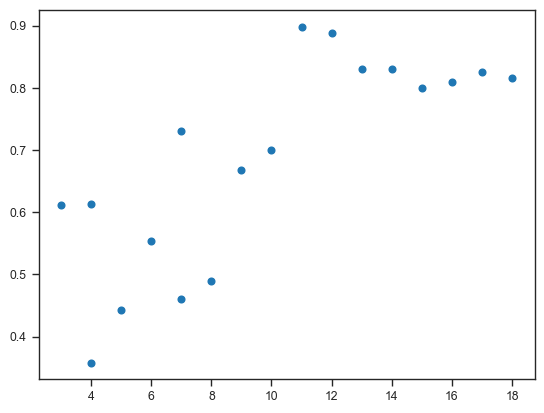

In [97]:
for i,c in enumerate(arraydata.celsius[rep]):
    plt.plot(poly_len, poly_curve.iloc[:,i], 'o')
    plt.show()

Now running Mark Fornace's code to get melting temperature correct

In [109]:
df = pd.read_csv('./data/external/Compiled_DNA_Tm_Data - 348oligos.csv')
df.columns = ['number', 'length', 'sodium', 'DNA_conc', 'seq', 'Tm', 'Tm_pred0']

In [110]:
df

,number,length,sodium,DNA_conc,seq,Tm,Tm_pred0
0,1,16,0.12,0.000005,AAAAAAAGCTTTTTTT,44.0,42.16
1,2,16,0.12,0.000007,AACGTGAATTCTGGCA,58.3,57.21
2,3,16,1.00,0.000018,CAACTTGATATTAATA,52.0,55.66
3,4,16,1.00,0.000100,CATATTGGCCAATATG,65.3,64.53
4,5,17,0.10,0.000004,CTCGTACCTTCCGGTCC,60.6,63.05
...,...,...,...,...,...,...,...
343,221,30,0.12,0.000002,GCCCCTCCACTGGCCGACGGCAGCAGGCTC,79.8,81.19
344,222,30,0.22,0.000002,GCCCCTCCACTGGCCGACGGCAGCAGGCTC,83.6,84.19
345,223,30,0.62,0.000002,GCCCCTCCACTGGCCGACGGCAGCAGGCTC,87.1,89.33
346,224,30,1.02,0.000002,GCCCCTCCACTGGCCGACGGCAGCAGGCTC,87.7,91.80


In [126]:
def calculate_unpaired_fraction(row, model, kind):
    '''Calculate unpaired fraction either using equilibrium pair probabilities or structure free energies'''

    A = nupack.Strand(row.seq, name='A')

    if str(A) != str(~A): # heterodimer
        strands = {A: row.DNA_conc, ~A: row.DNA_conc}

    else: # homodimer. Only include the same strand once!
        strands = {A: row.DNA_conc}

    if kind == 'structure':
        duplex = '(' * A.nt() + '+' + ')' * A.nt()
        unpaired = '.' * A.nt() + '+' + '.' * A.nt()

        # secondary structure free energies
        energies = [nupack.structure_energy([A, ~A], s, model=model) for s in (unpaired, duplex)]

        # get Boltzmann factor including the concentration of the strand species, assuming ideal solution
        factor = np.exp(-model.beta * (energies[1] - energies[0])) * row.DNA_conc / nupack.constants.water_molarity(model.temperature)

        # structure free energies are assuming distinguishable strands, so if homodimer need to divide by 2 for indistinguishability
        if str(A) == str(~A):
            factor /= 2

        return 1 / (1 + factor) # to get fraction in the unpaired state

    elif kind == 'pairing':
        mytube = nupack.Tube(strands=strands, complexes=nupack.SetSpec(max_size=2), name='mytube')
        result = nupack.tube_analysis(tubes=[mytube], model=model, compute=['pairs'])
        # Cannot resolve the bug and giving up
        return result.tubes[mytube].fraction_bases_unpaired # equilbrium base pairing between all strands in the tube

    
def calculate_tm(row, model, kind):
    '''Simple Tm calculation using bisection to find where unpaired = paired population'''

    lo, hi = 0, 100

    if calculate_unpaired_fraction(row, model(lo, row.sodium), kind) > 0.5:
        return lo

    if calculate_unpaired_fraction(row, model(hi, row.sodium), kind) < 0.5:
        return hi

    while True:
        T = (lo + hi) / 2
        unpaired = calculate_unpaired_fraction(row, model(T, row.sodium), kind)

        if abs(unpaired - 0.5) < 1e-6:
            return T
        elif unpaired > 0.5:
            hi = T
        else:
            lo = T


from concurrent.futures import ThreadPoolExecutor as Exec

executor = Exec(4)

 
# Model generation function
model = lambda T, na: nupack.Model(material='dna', celsius=T, sodium=na)

 

jobs = np.array([[executor.submit(calculate_tm, r, model, kind) for _, r in df.iterrows()] for kind in ['structure']])
results = np.vectorize(lambda j: j.result())(jobs)

<Axes: xlabel='Tm', ylabel='Tm_pred'>

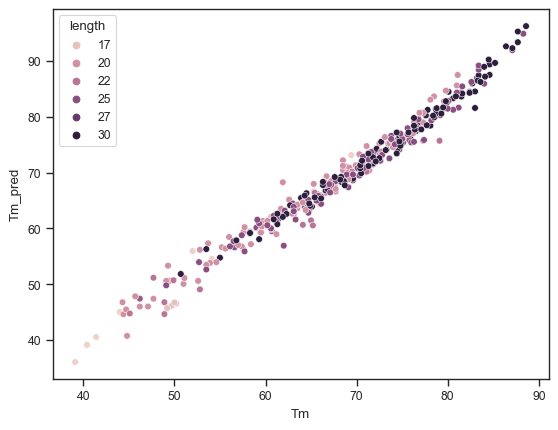

In [131]:
df['Tm_pred'] = results.flatten()
sns.scatterplot(data=df, x='Tm', y='Tm_pred', hue='length')

In [134]:
row = df.iloc[0,:]
kind = 'structure'

In [139]:
T = 37
mymodel = model(T, row.sodium)
A = nupack.Strand(row.seq, name='A')

if str(A) != str(~A): # heterodimer
    strands = {A: row.DNA_conc, ~A: row.DNA_conc}

else: # homodimer. Only include the same strand once!
    strands = {A: row.DNA_conc}

if kind == 'structure':
    duplex = '(' * A.nt() + '+' + ')' * A.nt()
    unpaired = '.' * A.nt() + '+' + '.' * A.nt()

    # secondary structure free energies
    energies = [nupack.structure_energy([A, ~A], s, model=mymodel) for s in (unpaired, duplex)]

    # get Boltzmann factor including the concentration of the strand species, assuming ideal solution
    factor = np.exp(-mymodel.beta * (energies[1] - energies[0])) * row.DNA_conc / nupack.constants.water_molarity(mymodel.temperature)

    # structure free energies are assuming distinguishable strands, so if homodimer need to divide by 2 for indistinguishability
    if str(A) == str(~A):
        factor /= 2

In [146]:
annotation.loc['WC2318']

Series                                WatsonCrick
ConstructType                          WC_7ntstem
bottomScaffold                                 GC
topScaffold                                    GC
RefSeq                         GCAATAGGAAACTATTGC
dH_NUPACK                                   -53.5
dS_NUPACK                               -0.153055
Tm_NUPACK                               76.397609
dG_37_ensemble_NUPACK                   -6.140709
TargetStruct                   (((((((....)))))))
dG_37_NUPACK                                -6.03
dG_37_ensemble_150mM_NUPACK             -4.792068
dG_37_ensemble_75mM_NUPACK              -4.278095
GC                                      38.888889
Tm_NUPACK_salt_corrected                62.887369
dG_37_NUPACK_salt_corrected             -4.121489
dH_NUPACK_salt_corrected                    -53.5
dS_NUPACK_salt_corrected                -0.153055
Name: WC2318, dtype: object